<a href="https://colab.research.google.com/github/starmpcc/KoSAIM2023-Transformer/blob/main/auto_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoSAIM 2023 Summer School - Transformers

## Topic: Diagnosis Code prediction from Discharge Summary

### Presentor: Junu Kim
- Contact: kjune0322@kaist.ac.kr

# Section 1. Setup

In [1]:
# Download Data
!gdown https://drive.google.com/file/d/1YXKCwROxMC9sqjisYnUkAonCmSaosh9A/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1nz4yKuIp1Tp-frkTbE5MXB6V3A50n-Qb/view?usp=sharing --fuzzy
!unzip transformer_data.zip


Downloading...
From: https://drive.google.com/uc?id=1YXKCwROxMC9sqjisYnUkAonCmSaosh9A
To: /content/transformer_data.zip
100% 206M/206M [00:08<00:00, 25.3MB/s]
Archive:  transformer_data.zip
  inflating: transformer_data/DIAGNOSES_ICD.csv  
  inflating: transformer_data/NOTEEVENTS_filtered.csv  


In [2]:
!ls transformer_data

DIAGNOSES_ICD.csv  NOTEEVENTS_filtered.csv


In [3]:
# Install Requirements

!pip install transformers
!pip install accelerate

# Import Libraries
import os

import pandas as pd
import torch
import numpy as np
import transformers
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.1 MB/s eta 0:00:00


# Section 2. Data Preprocessing

In [4]:
os.chdir('transformer_data')
print(os.listdir())

['NOTEEVENTS_filtered.csv', 'DIAGNOSES_ICD.csv']


In [5]:
# Make Labels

diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
diagnoses

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


## MIMIC-III Hierarchy
- SUBJECT_ID: Unique ID of a patient
- HADM_ID: Unique ID for each admission
- ICUSTAY_ID: Unique ID for ICU admission
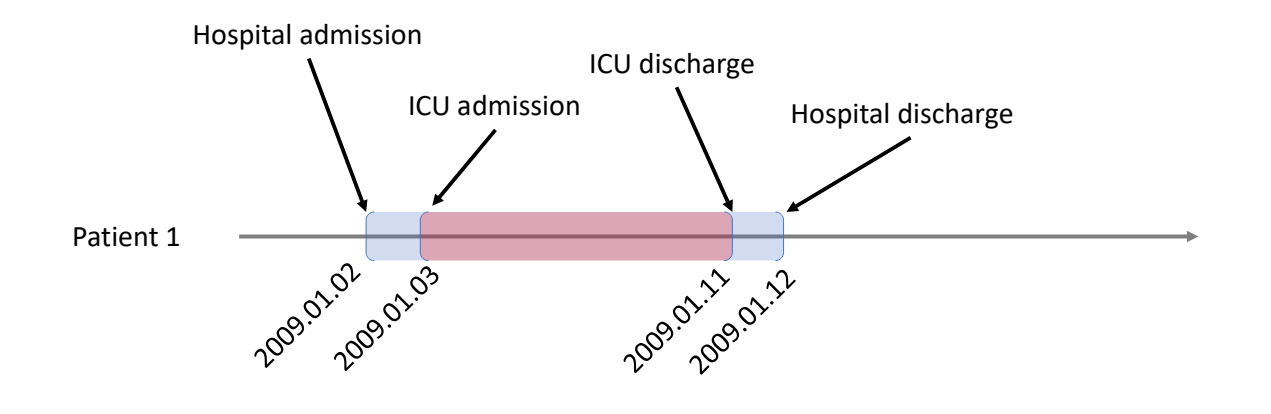
source: KAIST AI612 2022 Spring (Prof. Edward Choi)

In [6]:
# Filter Columns
diagnoses = diagnoses[['HADM_ID', 'ICD9_CODE']]
diagnoses

,HADM_ID,ICD9_CODE
0,172335,40301
1,172335,486
2,172335,58281
3,172335,5855
4,172335,4254
...,...,...
651042,188195,20280
651043,188195,V5869
651044,188195,V1279
651045,188195,5275


Text(0, 0.5, 'ICD9_CODE')

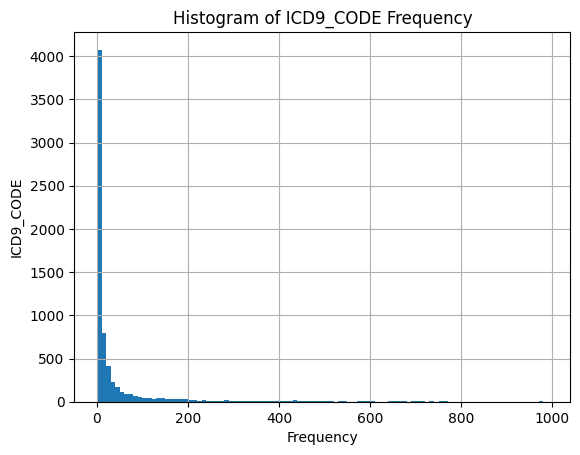

In [7]:
# Show Histogram of ICD9_CODE Frequency
diagnoses['ICD9_CODE'].value_counts().hist(
    bins=list(range(0, 1000, 10)),
    )
plt.title('Histogram of ICD9_CODE Frequency')
plt.xlabel('Frequency')
plt.ylabel('ICD9_CODE')

In [8]:
# Filter ICD9 Codes Appearing More than 1000 Times

#######
# Code Here
# counts = ???


######
print("Number of ICD9 Codes Appearing More than 1000 Times: ", len(counts))
diagnoses = diagnoses[diagnoses['ICD9_CODE'].isin(counts.index)]
diagnoses

Number of ICD9 Codes Appearing More than 1000 Times:  125


,HADM_ID,ICD9_CODE
1,172335,486
4,172335,4254
5,172335,2762
7,172335,2767
9,172335,45829
...,...,...
651023,161999,V4986
651031,189314,311
651038,168949,42731
651039,168949,V5861


## One-Hot Encoding

![image](https://miro.medium.com/v2/resize:fit:828/format:webp/1*ggtP4a5YaRx6l09KQaYOnw.png)

source: https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39

In [9]:
# Encode Labels
label = pd.get_dummies(diagnoses['ICD9_CODE'])
label['HADM_ID'] = diagnoses['HADM_ID']
label = label.groupby('HADM_ID').sum().astype(bool).astype(int).reset_index()
label

,HADM_ID,00845,0389,07054,2449,25000,25060,2639,2720,2724,...,V3000,V3001,V4501,V4581,V4582,V4986,V502,V5861,V5867,V667
0,100001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,100003,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,100007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100009,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56694,199993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56695,199994,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56696,199995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56697,199998,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# NOTE: Use Filtered File
# notes = pd.read_csv('NOTEEVENTS.csv')
# notes = notes[notes['CATEGORY'] == 'Discharge summary']

notes = pd.read_csv('NOTEEVENTS_filtered.csv')
notes

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...
...,...,...,...,...,...,...,...,...,...,...,...,...
59647,60411,59608,93924,135672.0,2104-06-14,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname 18321**],[**Known fir..."
59648,60412,59609,17782,155710.0,2112-03-31,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname 2706**], [**Known fir..."
59649,60413,59621,96333,183951.0,2197-06-18,NaN,NaN,Discharge summary,Addendum,NaN,NaN,Name: [**Known lastname 18357**]-[**Known las...
59650,60414,59622,66717,169165.0,2129-08-14,NaN,NaN,Discharge summary,Addendum,NaN,NaN,"Name: [**Known lastname **],[**Known firstnam..."


## Properties of Discharge Summary
- Handwritten -> Typos
- Use of abbreviations
- Structured by header
- (MIMIC notes) Deidentified placeholders "[\*\*2112-12-8\*\*]"


In [11]:
print(notes['TEXT'].iloc[6])

Admission Date:  [**2112-12-8**]              Discharge Date:   [**2112-12-10**]


Service: MEDICINE

Allergies:
Sulfonamides

Attending:[**First Name3 (LF) 1850**]
Chief Complaint:
Hypoxia

Major Surgical or Invasive Procedure:
none

History of Present Illness:
82 yo F with CAD, CHF, HTN, recent PE ([**10-17**]), who presents from
rehab with hypoxia and SOB despite Abx treatment for PNA x 3
days. The patient was in rehab after being discharged from here
for PE. She was scheduled to be discharged on [**12-6**]; on the day
prior to discharge she deveoped fever, hypoxia, and SOB. CXR
showed b/t lower lobe infiltrates. She was started on levoflox
and ceftriaxone on [**12-5**]. When she became hypoxic on NC they
brought her in to the ED.
.
In the [**Hospital1 18**] ED she was febrile to 102.7, P 109 BP 135/56 R 34
O2 90% on 3L. She was started on vanc and zosyn for broader
coverage, tylenol, and 2L NS.
.
The patient reports having sweats and cough before admission.
She complains of SOB and

In [12]:
# Filter Columns
notes = notes[['HADM_ID', 'TEXT']]

# Join with Labels
data = notes.merge(label, on='HADM_ID', how='inner')
data

,HADM_ID,TEXT,00845,0389,07054,2449,25000,25060,2639,2720,...,V3000,V3001,V4501,V4581,V4582,V4986,V502,V5861,V5867,V667
0,167853.0,Admission Date: [**2151-7-16**] Dischar...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,167853.0,Admission Date: [**2151-7-16**] Dischar...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,107527.0,Admission Date: [**2118-6-2**] Discharg...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,167118.0,Admission Date: [**2119-5-4**] D...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,196489.0,Admission Date: [**2124-7-21**] ...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57650,129192.0,"Name: [**Known lastname 15324**], [**Known fi...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57651,117457.0,"Name: [**Known lastname 14938**], [**Known fi...",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
57652,171593.0,"Name: [**Known lastname **], [**Known firstna...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57653,131944.0,"Name: [**Known lastname **], [**Known firstna...",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Shuffle and  Train, Validation, Test Split
from sklearn.model_selection import train_test_split

data = data.sample(frac=1, random_state=42)
train, valid = train_test_split(data, test_size=0.2, random_state=42)
valid, test = train_test_split(valid, test_size=0.5, random_state=42)

print("Length of Train: ", len(train))
print("Length of Valid: ", len(valid))
print("Length of Test: ", len(test))
train

Length of Train:  46124
Length of Valid:  5765
Length of Test:  5766


,HADM_ID,TEXT,00845,0389,07054,2449,25000,25060,2639,2720,...,V3000,V3001,V4501,V4581,V4582,V4986,V502,V5861,V5867,V667
23641,179330.0,Admission Date: [**2163-6-23**] Dischar...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56377,125347.0,Admission Date: [**2192-12-1**] ...,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1777,158703.0,Admission Date: [**2195-4-15**] ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28752,167728.0,Admission Date: [**2193-1-12**] Dischar...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,196357.0,Admission Date: [**2143-4-20**] ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,197210.0,Admission Date: [**2118-11-1**] ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16708,182577.0,"Name: [**Known lastname **], [**Known firstna...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7640,143916.0,Admission Date: [**2159-7-18**] ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
23571,174687.0,Admission Date: [**2148-5-25**] Discharg...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


# Section 3. Build Model

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load Model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpie/tiny-clinicalbert")
model = AutoModelForSequenceClassification.from_pretrained("nlpie/tiny-clinicalbert", num_labels=125, problem_type="multi_label_classification")
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

## Tokenizer
- Convert text to integers
![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*f8NBZIutC7PuGo21rsVVkw.png)

source: https://satish1v.medium.com/tokenization-for-bert-models-5c20734d1aca




In [16]:
tokenized = tokenizer.encode("KoSAIM 2023 Summer School")
print(tokenized)
for i in tokenized:
  print(i, '\t',tokenizer.decode([i]))

[101, 19892, 8055, 13371, 17881, 1495, 2659, 1323, 102]
101 	 [CLS]
19892 	 Ko
8055 	 ##SA
13371 	 ##IM
17881 	 202
1495 	 ##3
2659 	 Summer
1323 	 School
102 	 [SEP]


## Make Model Input

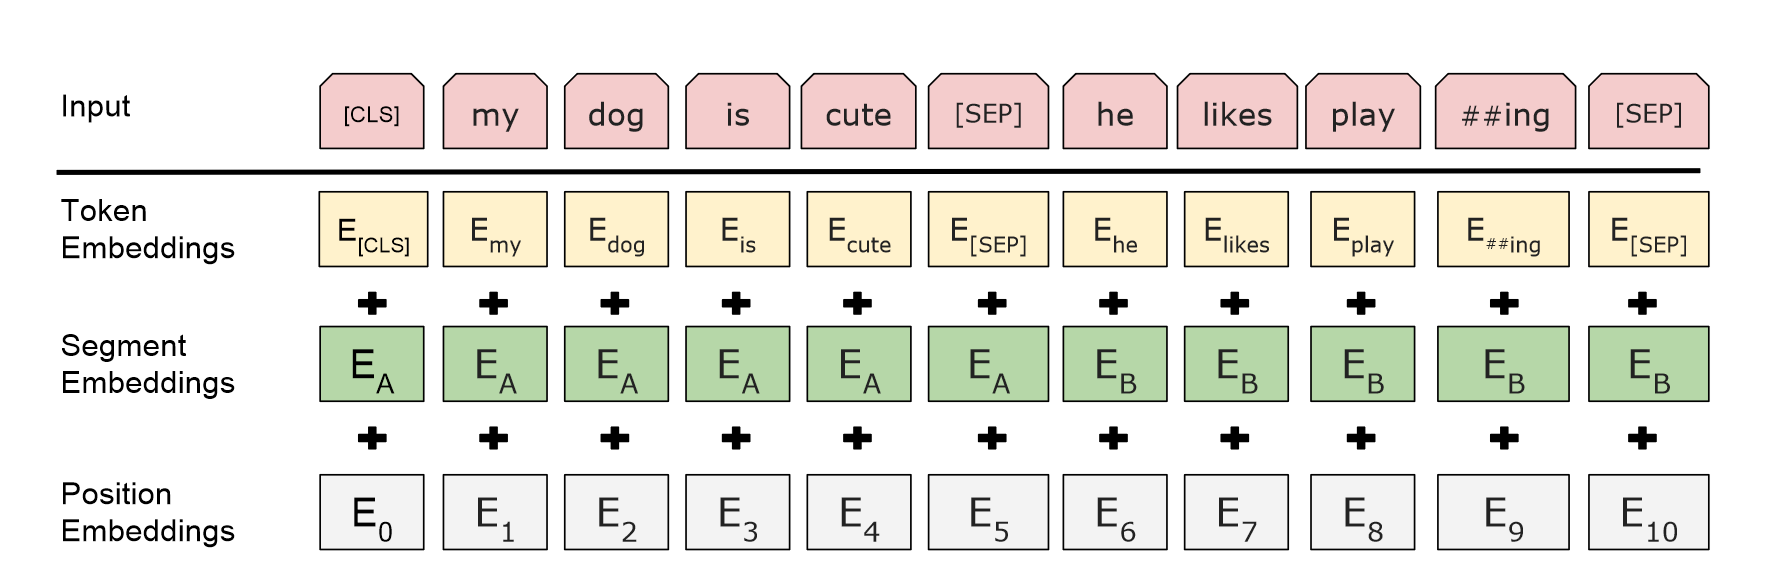

source: Attention is all you need (2017)


In [17]:
# Make Dataset and Dataloader

from torch.utils.data import Dataset, DataLoader

class NoteData(Dataset):
    def __init__(self, data, tokenizer):
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['TEXT']

        ########
        # Code Here
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=,
            max_length=512,
            padding=,
            return_attention_mask=,
            return_token_type_ids=,
            truncation=,
            return_tensors='pt',
            )
        #######
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'labels': torch.tensor(np.asarray(row[2:].values, dtype=np.int32), dtype=torch.float),
            }


In [18]:
train_dataset = NoteData(train, tokenizer)
valid_dataset = NoteData(valid, tokenizer)
test_dataset = NoteData(test, tokenizer)

In [19]:
print(train_dataset[0])
print(tokenizer.decode(train_dataset[0]['input_ids']))

{'input_ids': tensor([  101, 24930, 11234, 14265,   131,   164,   115,   115, 22148,  1495,
          118,   127,   118,  1695,   115,   115,   166, 14856,  7111,  2176,
        14265,   131,   164,   115,   115, 22148,  1495,   118,   129,   118,
          130,   115,   115,   166, 14265,  1104, 20729,   131,   164,   115,
          115, 22148,  1495,   118,   127,   118,  1695,   115,   115,   166,
         9850,   131,   143,  2516,   131,   151,  2064,   145,  6258, 18082,
         2069,  3663,   131,  6008,  1873,   164,   115,   115, 13915,  1314,
        16124,  5766,  1571,  1545,  1604,   115,   115,   166,  1110,   170,
         1476,   118,  1989,  5930,   138,  1873,  4120,  1106,  1103,   151,
         9741,  2591,  1111,  2492,  1104,  3073, 21943, 20172,  1120,  1476,
         2277,  1104,   176, 16144,  2116,  1113,   164,   115,   115, 22148,
         1495,   118,   127,   118,  1695,   115,   115,   166,   119,  1153,
         1108,  1255,  1106,   170,  3383,   118, 

## AUROC, AUPRC
![image](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Precision-Recall_tradeoff.png/621px-Precision-Recall_tradeoff.png?20190419204626)

source: https://commons.wikimedia.org/wiki/File:Precision-Recall_tradeoff.png

|AUROC|AUPRC|
|---|---|
|![image](https://machinelearningmastery.com/wp-content/uploads/2019/10/ROC-Curve-of-a-Logistic-Regression-Model-and-a-No-Skill-Classifier.png)|![image](https://machinelearningmastery.com/wp-content/uploads/2020/01/Precision-Recall-Curve-of-a-Logistic-Regression-Model-and-a-No-Skill-Classifier2.png)|

source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

In [20]:
from sklearn.metrics import roc_auc_score, average_precision_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = torch.sigmoid(torch.tensor(logits)).detach().numpy()
    return {
        "macro_auroc": roc_auc_score(labels, preds, average='macro'),
        #######
        # Code Here
        "macro_auprc":
        "micro_auroc":
        "micro_auprc":
        ######
    }

In [21]:
from transformers import Trainer, TrainingArguments

# Define Training Arguments
training_args = TrainingArguments(
    ########
    # Code Here
    output_dir='./results',
    num_train_epochs=,
    per_device_train_batch_size=,
    per_device_eval_batch_size=,
    logging_dir='./logs',
    logging_steps=,
    evaluation_strategy=,
    save_strategy=,
    load_best_model_at_end=,
    ########
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,

)

In [22]:
# Train Model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro Auroc,Macro Auprc,Micro Auroc,Micro Auprc
1,0.174100,0.180298,0.598116,0.078033,0.736249,0.177384


TrainOutput(global_step=1442, training_loss=0.2588189003702341, metrics={'train_runtime': 1013.0061, 'train_samples_per_second': 45.532, 'train_steps_per_second': 1.423, 'total_flos': 666826897870848.0, 'train_loss': 0.2588189003702341, 'epoch': 1.0})

In [23]:
# Test Model
pred = trainer.predict(test_dataset)
print(pred.metrics)

{'test_loss': 0.180869922041893, 'test_macro_auroc': 0.596897594850994, 'test_macro_auprc': 0.07730790436850954, 'test_micro_auroc': 0.7384312044711814, 'test_micro_auprc': 0.18079827893982103, 'test_runtime': 75.0404, 'test_samples_per_second': 76.839, 'test_steps_per_second': 2.412}


In [33]:
print("Prediction: ", (trainer.model(test_dataset[1]['input_ids'].unsqueeze(0).to('cuda')).logits >=-1).squeeze().nonzero().tolist())
print("Label: ", test_dataset[1]['labels'].nonzero().tolist())
tokenizer.decode(test_dataset[1]['input_ids'])

Prediction:  [[36], [54]]
Label:  [[8], [15], [36], [50], [51], [67]]


'[CLS] Admission Date : [ * * 2191 - 11 - 21 * * ] Discharge Date : [ * * 2191 - 11 - 24 * * ] Service : MEDICINE Allergies : Heparin Agents Attending : [ * * First Name3 ( LF ) 2745 * * ] Chief Complaint : Palpitations Major Surgical or Invasive Procedure : None History of Present Illness : 83 M with pmhx of afib, cva, recent dx of high grade glioma in l cerebral peduncle ) was enroute to [ * * Hospital1 18 * * ] for 1st session xrt, transport noted he was tachypneic, also had aspiration event. He was started on oxygen, at XRT he was noted to have a O2 sat of 97, but w / an irregular rapid HR 158.. In ED, VS, 98. 5 126 108 / 54 then 94 / 68 20 97RA received 1L NS BP rose to the 110s, then received dilt 10mg IVx2 HR decreased to 90s - 105. Also loaded with 60mg PO dilt. He also received a CTA, no noted PE, and head CT without significant change. On arrival, he did not complain of dizziness, chest pain, palpitations, nausea, vomitting. Has felt subjective shortness of breath and feveris